# ANN Classifier example in Python

#### This is a simple tutorial for applying our ANN Classifier model on AML samples. 
- Our color list follows a simple methodology of lightening cell-type color as we proceed from immature cells to mature cells 
- Our Model is located in the Model folder and it needs to be loaded before running the classification
- You can run the model by classification function.

** Enjoy it as much as we do! :)

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy.sparse as sp
import urllib.request
import os

#Disable some annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:

#Download files if they are not there.
if not os.path.exists("Model"):
    os.makedirs("Model")
if not os.path.exists("Model/ANNClassifier_features.txt"):
    urllib.request.urlretrieve("https://nextcloud.computecanada.ca/index.php/s/BCXjka8wcrCyNas/download",
                               "Model/ANNClassifier_features.txt")
if not os.path.exists("Model/ANNClassifier.sav"):
    urllib.request.urlretrieve("https://nextcloud.computecanada.ca/index.php/s/c2X5MyEsWmRmLCP/download",
                               "Model/ANNClassifier.sav")    


if not os.path.exists("test_data"):
    os.makedirs("test_data")
if not os.path.exists("test_data/GallenFull_integrated.h5ad"):
    urllib.request.urlretrieve("https://nextcloud.computecanada.ca/index.php/s/SiQ7pY4CYRDWAWk/download",
                               "test_data/GallenFull_integrated.h5ad")



Color palette we love:

In [12]:
color_palette = { 
#purple
'CD34+ HSC' : '#5A3AAB',
'CD34+ HSC-cycle' : '#7F38CF',
'CD34+ MultiLin' : '#BF7EED',

#Myeloid lineage  #blue
'Promyelocyte': '#365D93',
'Myelocyte': '#4D7BA8',

'Metamyelocyte/Band neutrophil': '#6489BD',
'S100A+ preNeutrophil': '#7AA7D2',
'S100A+ preNeutrophil (cycling)': '#91C5E7',
    
'CD14+MHCIIlow monocyte': '#2357F9',
'CD14+MHCIIhigh monocyte': '#5E80FF',
'CD16+ monocyte': '#1242e4',
'Macrophage': '#0F35B0',
    
# Dendritic cell : green     
'CDP': '#009999',
'cDC1': '#00E6E6',
'cDC2 (cycling)': '#00B2B2',
'cDC2': '#00CCCC',
'MoDC': '#28b5f7',

'pre-pDC (myeloid origin)': '#006633',
'pre-pDC (lymphoid origin)': '#008066',
'pDC': '#00FFFF',
 
'Mast cell' : '#575f88' , 
    
# Ery #red
'CD34+ MEP' : '#78222E',
'Megakaryocyte progenitor': '#8C2B3D',
'Megakaryocyte': '#A03D51',
'Platelet' : '#ed9393',

'Early SOX4+ erythroblast': '#B75268',
'Intermediate EPCAM+ erythroblast': '#C9617A',
'Late hemoglobin+ erythroblast': '#DA748C',
'Erythrocyte': '#DC143C',    

# Lymphocyte B
'CD34+ LMPP' : "#C83DE0",
'CD34+ CLP' : "#CF5BE3",
    
'preB cell (cycling)': '#D582F0', 
'preB cell':'#D986E7', 
'proB cell (cycling)':'#E091E1', 
'proB cell':'#E69DDC', 
'Naive B cell': '#EEA9D6',
'Memory B cell':'#F3B6D1', 
'Plasma Cell' : '#C71585',

# Lymphocyte T/NK
'ILC' : '#faa997', 
'T/NK cell (cycling)': '#FF5733',
'Naive CD8 T cell': '#FF7F50',
'Naive CD4 T cell': '#FFA07A',
'Effector/Memory CD4 T cell': '#FFC2A7',
'Treg': '#FFD1A7',
'GZMK+ CD8 T cell': '#FEDCB3',
'GZMB+ CD8 T cell': '#FEE0C2',
'MAIT': '#FEE5D0',
'Gamma-delta T cell': '#FEEBDB',
'IFN-activated T cell': '#FEEDE6',
'CD16+ NK': '#FEC9A8',
'Tissue-resident NK cell': '#FED6BB',
'CD56+ NK': '#FEE2CE',

'Stromal' : "#ffd000" ,
   
}

## Classification

- Features are taken from HCA reference data (which was run with Cell Ranger (version 5) and  GRCh38 standard reference (Ensembl 98) )

In [4]:

# load features
features = pd.read_csv("Model/ANNClassifier_features.txt",header=None)
features = features[0].to_list()
# load the model 
model = pickle.load(open('Model/ANNClassifier.sav', 'rb'))


In [6]:
def classification(adata,features_all,model_all_cell_types):
        
    #adata was filtering for unexpressed genes. We add genes that are
    #in the model but not in adata. We add them as zero in a new adata
    absent_features = list(set(features_all) - set(adata.var.index)) 

    #Create a sparse matrix or zeros
    temp = sp.csr_matrix( (len(adata.obs.index),len(absent_features)), dtype=np.double)    
        
    #Create an index of column names, since csr_matrix dont have column names
    colnames = pd.Index(adata.var.index.to_list() +absent_features)
    
    #concatenate sparse matrices
    final_df = sp.hstack((sp.csr_matrix(adata.X), temp), format='csr') 
       
    #Reorder the columns in the expected order
    df_test_all_ct =final_df[:,colnames.get_indexer_for(features_all)]
    
    # annotate other cell types
    pred_others_cell_types = model_all_cell_types.predict(df_test_all_ct)
    adata.obs['ANNpredictions'] = pred_others_cell_types
    return adata



## Read in your sample here

In [8]:
sample= 'GallenFull_integrated.h5ad'

adata = sc.read_h5ad('test_data/'+sample)
adata

AnnData object with n_obs × n_vars = 15685 × 27899
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'RNA_snn_res.0.8', 'seurat_clusters', 'predicted.id', 'orig.predicted.id', 'cellTypeV2_2', 'RNA_snn_res.0.5'
    var: 'name'
    obsm: 'X_pca', 'X_umap', 'X_x_harmony'
    layers: 'counts'

<b> Normalization step:</b>
- We normalize over 10000 as it approximate median UMI in AML samples using our current chemistry

In [9]:
#Attention, the data needs to be logNormalized to a count per cell of 10000
# However, this test dataset was alread loaded log-normalized, so we don't do it again

if np.sum(adata.X.astype(np.int32)) == np.sum(adata.X):
    print("Log-Normalizing adata...")
    sc.pp.normalize_per_cell(adata, counts_per_cell_after = 10000)
    sc.pp.log1p(adata)
else:
    if np.all(np.round(np.sum(np.exp(adata.X)-1,axis=1),1) == 10000):
        print("Normalization skipped, the matrix appears to be already normalized.")
    else:
        raise ValueError("Error, the matrix does not contain raw counts and\
                          yet does not appear to be log-normalized to a count per cell of 10000")

Normalization skipped, the matrix appears to be already normalized.


###  Running the Classification function 

In [10]:
adata = classification(adata,features,model)

adata.obs['ANNpredictions'] = pd.Categorical(adata.obs['ANNpredictions'], categories= list(color_palette.keys()))


<b>- UMAP of result

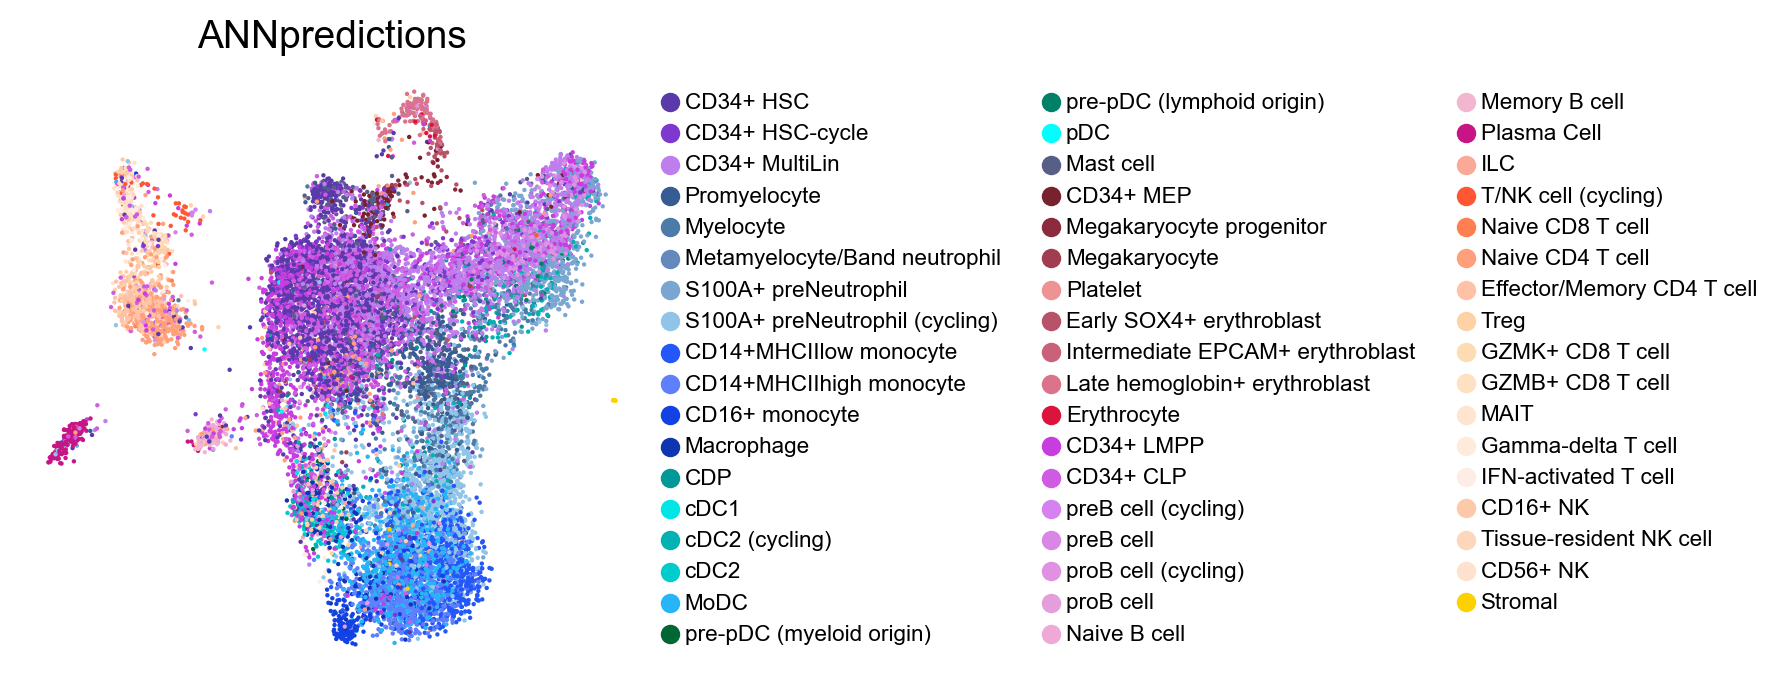

In [11]:
sc.set_figure_params(dpi=100, frameon = None)
sc.pl.umap(adata , color=['ANNpredictions'],palette=color_palette, s=10, legend_fontsize ='xx-small',
           legend_fontweight = 'light')

<b> You are done!